# Final Project

The goal is to pretty much try to create a zero shot model using a SPA-ENG, ENG-FRA datasets from manythings.org. 

The datasets are roughly balanced so for simplicity, downsampling will not be done to even the number of samples. There will be a slight bias coming from the ENG-FRA dataset

## Downloading of data

In [5]:
!wget http://www.manythings.org/anki/spa-eng.zip
!wget http://www.manythings.org/anki/fra-eng.zip

--2019-05-10 16:37:09--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2819791 (2.7M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.69M  10.5MB/s    in 0.3s    

2019-05-10 16:37:10 (10.5 MB/s) - ‘spa-eng.zip’ saved [2819791/2819791]

--2019-05-10 16:37:11--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3423204 (3.3M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   3.26M  12.2MB/s    in 0.3s    


In [0]:
!mkdir fra-eng
!mkdir spa-eng
!mv fra-eng.zip fra-eng
!mv spa-eng.zip spa-eng

In [7]:
!unzip fra-eng/fra-eng.zip -d fra-eng
!unzip spa-eng/spa-eng.zip -d spa-eng

Archive:  fra-eng/fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         
Archive:  spa-eng/spa-eng.zip
  inflating: spa-eng/_about.txt      
  inflating: spa-eng/spa.txt         


In [8]:
!ls

fra-eng  sample_data  spa-eng


In [0]:
# Merging the datasets together for wordpiece modeling
!cat fra-eng/fra.txt spa-eng/spa.txt > all.txt

## Modeling

In [10]:
!pip install sentencepiece # Installing package to deal with converting to wordpiece model

In [0]:
import sentencepiece as spm

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Embedding, Dense, Activation, Dropout, RepeatVector
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.random import shuffle
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import re


In [0]:
# Set seed for reproducible results
from numpy.random import seed
seed(1)

### Cleaning

#### Wordpiece modeling the corpus

https://github.com/google/sentencepiece
Looks like there is a pacakge to deal with the wordpiece model

https://github.com/google/sentencepiece/issues/285

In [13]:
# Creating a Wordpiece model using all of the data
## Add in the zero shot prefixes
vocab_size= 1000
model_prefix = 'model'
train_data_file = 'all.txt'

spm.SentencePieceTrainer.Train(f'--input={train_data_file} --model_prefix={model_prefix} --user_defined_symbols=<2es>,<2fra>,<2en>,<EOS> --vocab_size={vocab_size} --model_type=bpe')

True

In [14]:
# Loading the piecer
sp = spm.SentencePieceProcessor()
sp.Load("model.model")

True

##### Testing the encoder / decoder

In [15]:
sp.EncodeAsPieces("<2en> This is a test")

['▁', '<2en>', '▁This', '▁is', '▁a', '▁t', 'est']

In [16]:
sp.DecodePieces(['▁This', '▁is', '▁a', '▁t', 'est'])

'This is a test'

In [17]:
!head all.txt

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !


In [18]:
sp.EncodeAsPieces("Va !")

['▁V', 'a', '▁!']

In [19]:
sp.DecodePieces(['▁V', 'a', '▁!'])

'Va !'

In [20]:
sp.EncodeAsPieces("sdlfkhsdlkfh")

['▁s', 'd', 'l', 'f', 'k', 'h', 's', 'd', 'l', 'k', 'f', 'h']

In [21]:
sp.EncodeAsPieces("Ça suffit !")

['▁', 'Ç', 'a', '▁su', 'ff', 'it', '▁!']

In [22]:
sp.encode_as_ids('<2fra> This is a test <EOS>')

[419, 4, 355, 86, 8, 7, 52, 419, 6]

In [23]:
sp.decode_ids([419, 4, 355, 86, 8, 7, 52, 419, 6])

'<2fra> This is a test <EOS>'

#### Dealing with the dataset

https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

https://towardsdatascience.com/neural-machine-translation-using-seq2seq-with-keras-c23540453c74

In [0]:
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text and clean up tab delimination into list
        text = file.read().strip().split('\n')
        file.close()
        cleaned_text = [i.split('\t') for i in text]
        return cleaned_text

In [0]:
# Get cleaned corpus
spa_en = read_text("spa-eng/spa.txt")
fra_en = read_text("fra-eng/fra.txt")

In [0]:
# Add in the special characters for translation directions
spa_en = [['<2spa> ' + x[0] + ' <EOS>', '<2en> ' + x[1] + ' <EOS>'] for x in spa_en]
fra_en = [['<2fra> ' + x[0] + ' <EOS>', '<2en> ' + x[1] + ' <EOS>'] for x in fra_en]

In [27]:
spa_en[0]

['<2spa> Go. <EOS>', '<2en> Ve. <EOS>']

[Text(0, 0.5, 'Number of Language Pairs'),
 Text(0.5, 0, 'Language pair'),
 Text(0.5, 1.0, 'Difference between number of language pairs')]

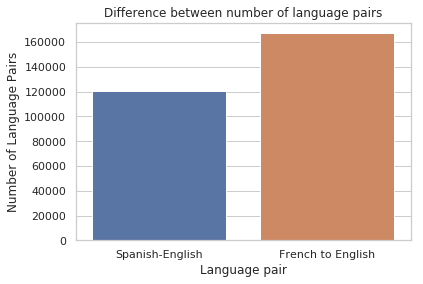

In [28]:
# Look at the number of language pairs
sns.set(style="whitegrid")
g = sns.barplot(['Spanish-English', 'French to English'], [len(spa_en), len(fra_en)])
g.set(xlabel='Language pair', ylabel='Number of Language Pairs', title = "Difference between number of language pairs")

As both datasets are unbalanced, both samples will actually be downsampled down to the target number to balance the datasets in order to trim down computations.

In [0]:
#Trim down maximum
num_sentences = 40000
shuffle(spa_en)
spa_en = spa_en[:num_sentences]
shuffle(fra_en)
fra_en = fra_en[:num_sentences]

In [30]:
len(spa_en), len(fra_en)

(30000, 30000)

In [0]:
# Tokenize model with wordpiece model version
en_only_spa_wp = [sp.encode_as_ids(i[0]) for i in spa_en]
spa_only_en_wp = [sp.encode_as_ids(i[1]) for i in spa_en]
en_only_fra_wp = [sp.encode_as_ids(i[0]) for i in fra_en]
fra_only_en_wp = [sp.encode_as_ids(i[1]) for i in fra_en]


In [0]:
# Ensure that there are up to 2000 wordmaps from tokenizer
encoder_vocab = set()
for i in spa_only_en_wp:
  for z in i:
    encoder_vocab.add(z)
    
for i in en_only_fra_wp:
  for z in i:
    encoder_vocab.add(z)
    
encoder_vocab_size = len(encoder_vocab) + 1

decoder_vocab = set()
for i in en_only_spa_wp:
  for z in i:
    decoder_vocab.add(z)
    
for i in fra_only_en_wp:
  for z in i:
    decoder_vocab.add(z)
    
decoder_vocab_size = len(decoder_vocab) + 1

In [33]:
print("Encoder vocab size: " + str(encoder_vocab_size))
print("Decoder vocab size: " + str(decoder_vocab_size))

Encoder vocab size: 469
Decoder vocab size: 485


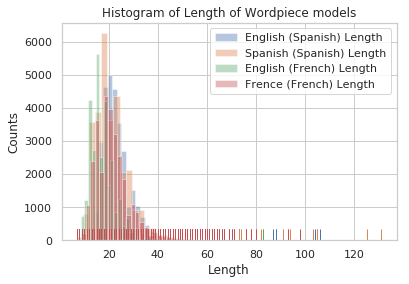

In [34]:
# Check the length of the longest of each dataset
en_only_spa_length = [len(i) for i in en_only_spa_wp]
spa_only_en_length = [len(i) for i in spa_only_en_wp]
en_only_fra_length = [len(i) for i in en_only_fra_wp]
fra_only_en_length = [len(i) for i in fra_only_en_wp]

g = sns.distplot(en_only_spa_length, kde=False, rug=True, label = 'English (Spanish) Length')
g = sns.distplot(spa_only_en_length, kde=False, rug=True, label = 'Spanish (Spanish) Length')
g = sns.distplot(en_only_fra_length, kde=False, rug=True, label = 'English (French) Length')
g = sns.distplot(fra_only_en_length, kde=False, rug=True, label = 'Frence (French) Length')
g.set_title("Histogram of Length of Wordpiece models")
g.set_xlabel("Length")
g.set_ylabel("Counts")
g.legend()
g

In [35]:
max_length = max(max(en_only_spa_length), max(spa_only_en_length), max(en_only_fra_length), max(fra_only_en_length))
max_length

131

Most of the word pieces hover about 15 chunks but the maximum number of chunks is 140 so padding is needed to equalize the length.

In [0]:
# Combine datasets
data = spa_only_en_wp + en_only_fra_wp
targets = en_only_spa_wp + fra_only_en_wp

In [0]:
# Pad length to max len
data = pad_sequences(data,maxlen = max_length, padding='post')
targets = pad_sequences(targets,maxlen = max_length, padding='post')

In [0]:
# Define max length of encoder / decoder, should be the same because of padding
max_encoder_seq_length = max([len(text) for text in data])
max_decoder_seq_length = max([len(text) for text in targets])

In [39]:
max_encoder_seq_length, max_decoder_seq_length

(131, 131)

In [40]:
# Prepare training and test data
train_x, test_x, train_y, test_y = train_test_split(data, targets, test_size=0.2, random_state = 1)
len(train_x), len(test_x), len(train_y), len(test_y)

(48000, 12000, 48000, 12000)

In [41]:
# Inputs (sample_numbers, max sequence length)
train_x.shape, test_x.shape

((48000, 131), (12000, 131))

#### Model

In [0]:
batch_size = 256
num_epochs = 30
latent_dim = 512

In [0]:
num_decoder_tokens = decoder_vocab_size
num_encoder_tokens = encoder_vocab_size


In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [45]:
# model compilation
# Endoder/Decoder size defined by vocab size in sentencepiece earlier
# Encoder/Decoder sequence lengths are the same because of padding
model = define_model(vocab_size, vocab_size, max_encoder_seq_length, max_decoder_seq_length, latent_dim)

Instructions for updating:
Colocations handled automatically by placer.


In [46]:
encoder_vocab_size

469

In [47]:
train_x.shape

(48000, 131)

In [48]:
adam = optimizers.Adam(lr = 1E-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer= adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 131, 512)          256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 131, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 131, 512)          2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 131, 500)          256500    
Total params: 4,710,900
Trainable params: 4,710,900
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Save checkpoints
filename = 'model3'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train model
history = model.fit(train_x, train_y.reshape(train_y.shape[0], train_y.shape[1],1),
                    epochs=num_epochs, batch_size=batch_size, validation_split = 0.2,
                    callbacks=[checkpoint],
                    validation_data = (test_x, test_y.reshape(test_y.shape[0], test_y.shape[1],1)),
                    verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 114s 2ms/step - loss: 0.6438 - val_loss: 0.6480

Epoch 00001: val_loss improved from inf to 0.64795, saving model to model2
Epoch 2/30
48000/48000 [==============================] - 114s 2ms/step - loss: 0.6427 - val_loss: 0.6434

Epoch 00002: val_loss improved from 0.64795 to 0.64338, saving model to model2
Epoch 3/30
48000/48000 [==============================] - 114s 2ms/step - loss: 0.6412 - val_loss: 0.6411

Epoch 00003: val_loss improved from 0.64338 to 0.64113, saving model to model2
Epoch 4/30
48000/48000 [==============================] - 113s 2ms/step - loss: 0.6404 - val_loss: 0.6389

Epoch 00004: val_loss improved from 0.64113 to 0.63892, saving model to model2
Epoch 5/30
48000/48000 [==============================] - 114s 2ms/step - loss: 0.6389 - val_loss: 0.6386

Epoch 00005: val_loss improved from 0.63892 to 0.63864, saving model to model2
Epoch 6/30
48000/48000 [

In [0]:
# Save model permanently to on prem local(Google Colab)
from google.colab import files
files.download('model3')

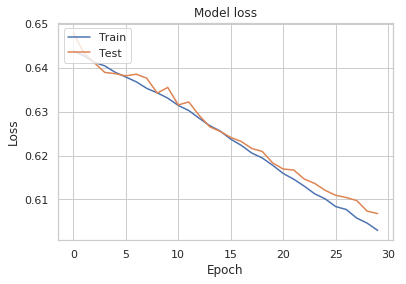

In [77]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# Create translate class
class Translate:
  '''
  Translation class
  Input:
  Sentence to translate(string)
  Target Language (French, Spanish, or English)
  Output:
  Translated Sentence
  '''
  def __init__(self, raw_sentence, target_lang):
    self.raw_sentence = raw_sentence
    self.target_lang = target_lang
  
  def encode_sentence(self, sentence):
    '''
    Wordmap the sentence into integers
    '''
    return(sp.encode_as_ids(sentence))
  
  def decode_sentence(self, word_map_vector):
    '''
    Decode the wordmap back into target sentence
    '''
    return(sp.decode_ids(word_map_vector))
  
  def predict_translation(self):
    '''
    Predicts sentence based on target
    '''
    # Append start stop based on target language
    if self.target_lang == 'English':
      input_lang = '<2en> '
    elif self.target_lang == 'French':
      input_lang = '<2fra> '
    elif self.target_lang == 'Spanish':
      input_lang = '<2spa> '
    else:
      return('Error: Please input either English, French or Spanish')
    
    
    # Encode sentence
    sentence = []
    mapped_sentence = self.encode_sentence(input_lang + self.raw_sentence + ' <EOS>')
    sentence.append(mapped_sentence)
    
    # Pad and reshape mapped_sentence
    mapped_sentence = pad_sequences(sentence,maxlen = max_length, padding='post')
    
    # Predict
    prediction = model.predict_classes(mapped_sentence.reshape(mapped_sentence.shape[0], mapped_sentence.shape[1]))
    # Decode from softmax
    demapped_sentence = self.decode_sentence([int(x) for x in prediction[0]])
    # Return decoded string
    return(demapped_sentence)

##### Testing some translations

These are some sample translations to test the model across directly translated sentence pairs as well as zero shot translations with Spanish to French

In [184]:
# English to French(Explicitly trained)
Translate("I am here.", "French").predict_translation() 


'<2en> Je suisai ..  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ '

In [185]:
# Spanish to English(Explicited trained)
Translate("Dónde está el baño", "Spanish").predict_translation()

"<2en> C'estest est est est estss...  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ "

In [186]:
# Spanish to French(Zero Shot)
Translate("Dónde está el baño", "French").predict_translation() 


"<2en> Vous'eseses n n néé..   ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ "

In [189]:
# Testing English to Spanish
Translate("I am here.", "Spanish").predict_translation()

"<2en> Tom'a .. <EOS> ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ "

In [188]:
# English to French(Explicitly trained) with long sentence
Translate("I think bad things are happening but I am not sure what I can do about it. Could you maybe look into it?", "French").predict_translation() 

"<2en> P pense que que''''''erer que que que que de''''''''''''''''''''''' ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ "

In [191]:
# Gibberish(multi lang)
Translate("I think el gato est merveilleux", "English").predict_translation() 

" ⁇ 2spa ⁇  He''tt a the the the....  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ "

##### BLEU Scores

BLEU scores are evaluated by testing with and against the Google Translate version. There is a pretty higher rate of error due to not super cleaning the output from the prediction such as from the sentence start end tags and the zero padding being decoded.

In [0]:
# BLEU Scores

In [0]:
# ENG to FRENCH(Explicit)
eng_fra_scores = [sentence_bleu(Translate("My name is John.", "French").predict_translation().split(" "), "Mon nom est John.".split(" ")),
                  sentence_bleu(Translate("Where is the bathroom?", "French").predict_translation().split(" "), "Où se trouvent les toilettes?".split(" ")),
                  sentence_bleu(Translate("John, where are you?", "French").predict_translation().split(" "), "John, où es-tu?".split(" "))]

eng_fra_results = pd.DataFrame({'Language': 'ENG-FRA', 
                                'Input_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Target_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Score': eng_fra_scores})

In [0]:
# ENG TO SPANISH(Garbage)
eng_spa_scores = [sentence_bleu(Translate("My name is John.", "Spanish").predict_translation().split(" "), "Mi nombre es John.".split(" ")),
                  sentence_bleu(Translate("Where is the bathroom?", "Spanish").predict_translation().split(" "), "¿Dónde está el baño?".split(" ")),
                  sentence_bleu(Translate("John, where are you?", "Spanish").predict_translation().split(" "), "Juan donde estas".split(" "))]

eng_spa_results = pd.DataFrame({'Language': 'ENG-SPA', 
                                'Input_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Target_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'John, où es-tu?'], 
                                'Score': eng_spa_scores})

In [0]:
# SPANISH TO ENG(Explicit)
spa_eng_scores = [sentence_bleu(Translate("Mi nombre es John.", "English").predict_translation().split(" "), "My name is John.".split(" ")),
                  sentence_bleu(Translate("¿Dónde está el baño?", "English").predict_translation().split(" "), "Where is the bathroom?".split(" ")),
                  sentence_bleu(Translate("Juan donde estas", "English").predict_translation().split(" "), "John, where are you?".split(" "))]

spa_eng_results = pd.DataFrame({'Language': 'SPA-ENG', 
                                'Input_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'Juan donde estas'], 
                                'Target_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Score': spa_eng_scores})

In [0]:
# SPANISH TO FRENCH(Zero shot)
spa_fra_scores = [sentence_bleu(Translate("Mi nombre es John.", "French").predict_translation().split(" "), "Mon nom est John.".split(" ")),
                  sentence_bleu(Translate("¿Dónde está el baño?", "French").predict_translation().split(" "), "Où se trouvent les toilettes?".split(" ")),
                  sentence_bleu(Translate("Juan donde estas", "French").predict_translation().split(" "), "John, où es-tu?".split(" "))]

spa_fra_results = pd.DataFrame({'Language': 'SPA-FRA', 
                                'Input_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'Juan donde estas'], 
                                'Target_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Score': spa_fra_scores})

In [0]:
# FRENCH TO ENG(Garbage)
fra_eng_scores = [sentence_bleu(Translate("Mon nom est John.", "French").predict_translation().split("My name is John."), "".split(" ")),
                  sentence_bleu(Translate("Où se trouvent les toilettes?", "French").predict_translation().split("Where is the bathroom?"), "".split(" ")),
                  sentence_bleu(Translate("John, où es-tu?", "French").predict_translation().split(" "), "".split("John, where are you?"))]

fra_eng_results = pd.DataFrame({'Language': 'FRA-ENG', 
                                'Target_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Input_Sentence': ['My name is John.', 'Where is the bathroom', 'John, where are you?'], 
                                'Score': fra_eng_scores})

In [0]:
# FRENCH TO SPANISH(Garbage)
fra_spa_scores = [sentence_bleu(Translate("Mon nom est John.", "French").predict_translation().split(" "), "Mi nombre es John.".split(" ")),
                  sentence_bleu(Translate("Où se trouvent les toilettes?", "French").predict_translation().split(" "), "¿Dónde está el baño?".split(" ")),
                  sentence_bleu(Translate("John, où es-tu?", "French").predict_translation().split(" "), "Juan donde estas".split(" "))]

fra_spa_results = pd.DataFrame({'Language': 'SPA-FRA', 
                                'Input_Sentence': ['Mon nom est John.', 'Où se trouvent les toilettes?', 'John, où es-tu?'], 
                                'Target_Sentence': ['Mi nombre es John.', '¿Dónde está el baño?', 'Juan donde estas'], 
                                'Score': fra_spa_scores})

In [0]:
# Plot results
